In `acl.all.tsv` you'll find 7,188 papers published at major NLP venues (ACL, EMNLP, NAACL, TACL, etc.) between 2013 and 2020.  Your job is to use topic modeling to discover what topics in NLP have been increasing or decreasing in use over this time.  Here is a sample of the data we'll use:

|id|year of publication|title|abstract|
|---|---|---|---|
|pimentel-etal-2020-phonotactic|2020|Phonotactic Complexity and Its Trade-offs|We present methods for calculating a measure of phonotactic complexity---bits per phoneme--- that permits a straightforward cross-linguistic comparison. When given a word, represented as a sequence of phonemic segments such as symbols in the international phonetic alphabet, and a statistical model trained on a sample of word types from the language, we can approximately measure bits per phoneme using the negative log-probability of that word under the model. This simple measure allows us to compare the entropy across languages, giving insight into how complex a language's phonotactics is. Using a collection of 1016 basic concept words across 106 languages, we demonstrate a very strong negative correlation of − 0.74 between bits per phoneme and the average length of words.|
|wang-etal-2020-amr|2020|AMR-To-Text Generation with Graph Transformer|Abstract meaning representation (AMR)-to-text generation is the challenging task of generating natural language texts from AMR graphs, where nodes represent concepts and edges denote relations. The current state-of-the-art methods use graph-to-sequence models; however, they still cannot significantly outperform the previous sequence-to-sequence models or statistical approaches. In this paper, we propose a novel graph-to-sequence model (Graph Transformer) to address this task. The model directly encodes the AMR graphs and learns the node representations. A pairwise interaction function is used for computing the semantic relations between the concepts. Moreover, attention mechanisms are used for aggregating the information from the incoming and outgoing neighbors, which help the model to capture the semantic information effectively. Our model outperforms the state-of-the-art neural approach by 1.5 BLEU points on LDC2015E86 and 4.8 BLEU points on LDC2017T10 and achieves new state-of-the-art performances.|


First, let's read in the data and train a topic model on it (you are free to set the number of topics $K$ as you see fit.

In [1]:
import nltk
import re
import gensim
from gensim import corpora
import operator

nltk.download('stopwords')
from nltk.corpus import stopwords

import numpy as np
import random

random.seed(1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cheny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
K=5

In [3]:
stop_words = stopwords.words('english')

In [4]:
def filter(word, stopwords):
    
    """ Function to exclude words from a text """
    
    # no stopwords
    if word in stopwords:
        return False
    
    # has to contain at least one letter
    if re.search("[A-Za-z]", word) is not None:
        return True
    
    return False

In [5]:
def read_docs(dataFile, stopwords):
    
    names=[]    
    docs=[]
   
    with open(dataFile, encoding="utf-8") as file:
        for line in file:
            cols=line.rstrip().split("\t")
            idd=cols[0]
            name=cols[2]
            year=int(cols[1])
        
            text=cols[3]
            
            tokens=nltk.word_tokenize(text.lower())
            tokens=[x for x in tokens if filter(x, stopwords)]
            docs.append(tokens)
            names.append((name, year))
    return docs, names

In [6]:
dataFile="../data/acl.all.tsv"
data, doc_names=read_docs(dataFile, stop_words)

We will convert the data into a bag-of-words representation using gensim's [corpora.dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html) methods.

In [7]:
# Create vocab from data; restrict vocab to only the top 10K terms that show up in at least 5 documents 
# and no more than 50% of all documents

dictionary = corpora.Dictionary(data)
dictionary.filter_extremes(no_below=5, no_above=.5, keep_n=10000)

In [8]:
# Replace dataset with numeric ids words in vocab (and exclude all other words)
corpus = [dictionary.doc2bow(text) for text in data]

Now let's run a topic model on this data using gensim's built-in LDA.

In [9]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=K, 
                                           passes=10,
                                           alpha='auto')

We can get a sense of what the topics are by printing the top 10 words with highest $P(word \mid topic)$ for each topic

In [10]:
for i in range(K):
    print("topic %s:\t%s" % (i, ' '.join([term for term, freq in lda_model.show_topic(i, topn=5)])))

topic 0:	word semantic embeddings models words
topic 1:	learning neural propose information models
topic 2:	translation models training neural language
topic 3:	languages language data parsing system
topic 4:	dataset question models language task


Now let's print out the documents that have the highest topic representation -- i.e., for a given topic $k$, the documents with highest $P(topic=k | document)$ -- in order to ground these topic summaries with actual documents that contain those topics.

In [11]:
topic_model=lda_model 
prob = {}

topic_docs=[]
for i in range(K):
    topic_docs.append({})
for doc_id in range(len(corpus)):
    doc_topics=topic_model.get_document_topics(corpus[doc_id])
    for topic_num, topic_prob in doc_topics:
        topic_docs[topic_num][doc_id]=topic_prob

for i in range(K):
    
    #print("%s\n" % ' '.join([term for term, freq in topic_model.show_topic(i, topn=5)]))
    sorted_x = sorted(topic_docs[i].items(), key=operator.itemgetter(1), reverse=True)
    
    cum_v = 0
    for k, v in sorted_x[:5]:
        cum_v += v
        print("%s\t%.3f\t%s" % (i,v,doc_names[k]))
        print(cum_v)
    
    
    prob[i] = cum_v        
    print()
    
    

0	0.994	('Can Network Embedding of Distributional Thesaurus Be Combined with Word Vectors for Better Representation?', 2018)
0.994389533996582
0	0.994	('Automatic Evaluation of Local Topic Quality', 2019)
1.9882630109786987
0	0.994	('Correlation Coefficients and Semantic Textual Similarity', 2019)
2.981887698173523
0	0.993	('Estimating Mutual Information Between Dense Word Embeddings', 2020)
3.97500216960907
0	0.993	('Enriching Word Embeddings with Temporal and Spatial Information', 2020)
4.967638075351715

1	0.996	('Heterogeneous Graph Attention Networks for Semi-supervised Short Text Classification', 2019)
0.9958751201629639
1	0.995	('A Neural Layered Model for Nested Named Entity Recognition', 2018)
1.9910861253738403
1	0.995	('Cross-Sentence N-ary Relation Extraction with Graph LSTMs', 2017)
2.986250579357147
1	0.995	('Dependency Graph Enhanced Dual-transformer Structure for Aspect-based Sentiment Classification', 2020)
3.9812464714050293
1	0.995	('Hyperbolic Capsule Networks for M

**Q1**: Use this basic framework to plot the distribution of a topic over time (between the years 2013-2020).  Specifically, given a document-topic distribution $\theta$ for an entire corpus such that $\theta_d$ is the document-topic distribution for document $d$ and $\theta_{d,i}$ is the probability of topic $i$ in document $d$, the relative frequency of topic $i$ at time $t$ is the sum of $\theta_{d,i}$ for all documents that are published in year $t$, divided by the total number of documents published in year $t$: 

$$
f(t, i) ={ \sum_{d \in D: date(d) = t} \theta_{d,i} \over \sum_{d \in D: date(d) = t} 1}
$$

For all of the $K$ topics you learn above, plot the distribution of that topic over time (i.e., the x-axis should be time from 2013-2020 and the y-axis should be the relative frequency value $f$ defined above).  Your output here should be $K$ line charts paired with their topic signatures (e.g., from `topic_model.show_topic`, so that we know what topic the chart corresponds to).  See below for sample code generating such a line chart with x, y inputs.

In [13]:
idx_2013 = []
data_2013 = []

idx_2014 = []
data_2014 = []

idx_2015 = []
data_2015 = []

idx_2016 = []
data_2016 = []

idx_2017 = []
data_2017 = []

idx_2018 = []
data_2018 = []

idx_2019 = []
data_2019 = []

idx_2020 = []
data_2020 = []



for i in range (len(doc_names)):
    if doc_names[i][1] == 2013:
        idx_2013.append(doc_names[i])
        data_2013.append(data[i])
        
    if doc_names[i][1] == 2014:
        idx_2014.append(doc_names[i])
        data_2014.append(data[i])
        
    if doc_names[i][1] == 2015:
        idx_2015.append(doc_names[i])
        data_2015.append(data[i])
        
    if doc_names[i][1] == 2016:
        idx_2016.append(doc_names[i])
        data_2016.append(data[i])
        
    if doc_names[i][1] == 2017:
        idx_2017.append(doc_names[i])
        data_2017.append(data[i])
        
    if doc_names[i][1] == 2018:
        idx_2018.append(doc_names[i])
        data_2018.append(data[i])
        
    if doc_names[i][1] == 2019:
        idx_2019.append(doc_names[i])
        data_2019.append(data[i])
        
    if doc_names[i][1] == 2020:
        idx_2020.append(doc_names[i])
        data_2020.append(data[i])

In [64]:
'''
input: 
k the ith topic in K that we care about 
yearly data list and the document list

output: 

'''

def a_function(data, idx, K):
    
    #build the gensim model for that specific year 
    dic = corpora.Dictionary(data)
    dictionary.filter_extremes(no_below=5, no_above=.5, keep_n=10000)
    
    corpus = [dictionary.doc2bow(text) for text in data]
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=K, 
                                           passes=10,
                                           alpha='auto')
    
    # innitialize the variables
    total_theta_d_i = {}
    total_doc = len(idx)
    
    #getting the theta_d_i for each topic K
    
    topic_docs=[]
    
    for i in range(K):
        topic_docs.append({})
        
    for doc_id in range(len(corpus)):
        doc_topics=topic_model.get_document_topics(corpus[doc_id])
        
        for topic_num, topic_prob in doc_topics:
            topic_docs[topic_num][doc_id]=topic_prob

    for i in range(K):

        print("%s\n" % ' '.join([term for term, freq in topic_model.show_topic(i, topn=5)]))
        total_theta_d_i[i] = sum(topic_docs[i].values())       
    
    return total_theta_d_i, total_doc

In [65]:
topic_list = []
data_list = []   

In [66]:
year_list = [(data_2013, idx_2013), (data_2014,idx_2014), (data_2015,idx_2015),( data_2016,idx_2016), (data_2017,idx_2017),
           (data_2018,idx_2018),(data_2019,idx_2019),(data_2020,idx_2020)]

In [67]:
for item in year_list:
    di, td = a_function(item[0], item[1], 5)

    topic_list.append(di)
    data_list.append(td)

word semantic embeddings models words

learning neural propose information models

translation models training neural language

languages language data parsing system

dataset question models language task

word semantic embeddings models words

learning neural propose information models

translation models training neural language

languages language data parsing system

dataset question models language task

word semantic embeddings models words

learning neural propose information models

translation models training neural language

languages language data parsing system

dataset question models language task

word semantic embeddings models words

learning neural propose information models

translation models training neural language

languages language data parsing system

dataset question models language task

word semantic embeddings models words

learning neural propose information models

translation models training neural language

languages language data parsing system

data

In [70]:
#f(t,i) is the sum of theta d/i for all documents that published at time t / sum of document published in time t  
f_list = []
    
for t in range(K):
    #print('topic is ' + str(t))
    l1 = []
    
    for year in range(len(data_list)):
        
        #print("the year is:" + str(year))
    
        f = (topic_list[year][t]) / data_list[year]
        l1.append(f)
        #print(l1)
    
    f_list.append(l1)
    #print('f is ' + str(f))

In [84]:
import matplotlib.pyplot as plt

def plot_category(a,b, topic):
    plt.title(topic)
    plt.xlabel('Years')
    plt.ylabel('Distribution')
    plt.plot(a,b)
    plt.show()


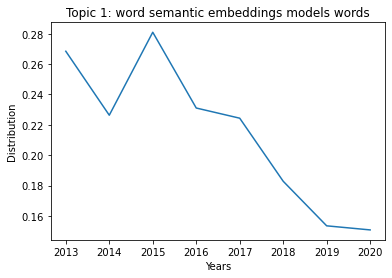

In [90]:
a=[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
t_1 =f_list[0]
plot_category(a,t_1, 'Topic 1: word semantic embeddings models words')


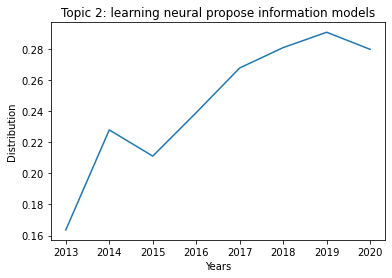

In [86]:
t_2 =f_list[1]
plot_category(a,t_2, 'Topic 2: learning neural propose information models')

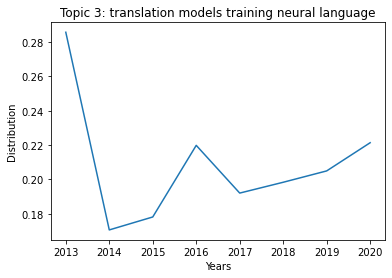

In [87]:
t_3 =f_list[2]
plot_category(a,t_3, 'Topic 3: translation models training neural language')

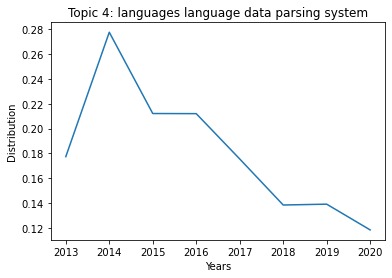

In [88]:
t_4 =f_list[3]
plot_category(a,t_4, 'Topic 4: languages language data parsing system')

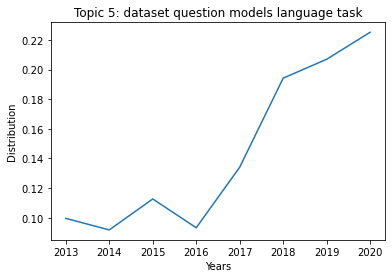

In [89]:
t_5 =f_list[4]
plot_category(a,t_5, 'Topic 5: dataset question models language task')